# Visualize example forecasts

In [1]:
import os
import sys
import yaml
import argparse
from glob import glob
from datetime import datetime, timedelta

import numpy as np
import xarray as xr

In [2]:
sys.path.insert(0, os.path.realpath('../libs/'))
import graph_utils as gu
import verif_utils as vu

In [3]:
config_name = os.path.realpath('plot_config.yml')

with open(config_name, 'r') as stream:
    conf = yaml.safe_load(stream)

In [4]:
# graph tools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature

%matplotlib inline

## Figure settings

In [5]:
need_publish = False

# True: publication quality figures
# False: low resolution figures in the notebook

if need_publish:
    dpi_ = conf['figure']['keys']['dpi']
else:
    dpi_ = 75

## Import data

In [6]:
# year range
year_range = conf['example']['year_range']
years_pick = np.arange(year_range[0], year_range[1]+1, 1).astype(str)

# lat/lon variables
OURS_dataset = xr.open_dataset(conf['geo']['geo_file_nc'])
x_OURS = np.array(OURS_dataset['longitude'])
y_OURS = np.array(OURS_dataset['latitude'])

lon_OURS, lat_OURS = np.meshgrid(x_OURS, y_OURS)

In [7]:
# ERA5 verif target
filename_ERA5 = sorted(glob(conf['example']['save_loc_target']))
filename_ERA5 = [fn for fn in filename_ERA5 if any(year in fn for year in years_pick)]

# merge yearly ERA5 as one
ds_ERA5 = [vu.get_forward_data(fn) for fn in filename_ERA5]
ds_ERA5_merge = xr.concat(ds_ERA5, dim='time')
    
# Select the specified variables and their levels
variables_levels = conf['example']['verif_variables']

# subset merged ERA5 and unify coord names
ds_ERA5_merge = vu.ds_subset_everything(ds_ERA5_merge, variables_levels)
ds_ERA5_merge = ds_ERA5_merge.rename({'latitude':'lat','longitude':'lon'})

In [8]:
# medium size model
filename_medium = sorted(glob(conf['example']['save_loc_base']+'*.nc'))
filename_medium = [fn for fn in filename_medium if any(year in fn for year in years_pick)]

# large model
filename_large = sorted(glob(conf['example']['save_loc_ours']+'*.nc'))
filename_large = [fn for fn in filename_large if any(year in fn for year in years_pick)]

## Pick your init and lead times

In [9]:
date_base = datetime(year_range[0], 1, 1)
N_12hours = len(filename_medium)
date_list = [date_base + timedelta(hours=12*i) for i in range(N_12hours)]

**Your [datetime] and [00Z/12Z] to visualize**

In [10]:
my_date = datetime(2019, 11, 18, 12)
ind_pick = date_list.index(my_date)

**Your lead time index to visualize**

In [11]:
example_lead_index = 239 # day-10

**Your variables**

In [12]:
varnames = ['V500', 'U500', 'T500', 'Q500', 'Z500', 'SP', 't2m']

In [13]:
dict_example = {}

print('Get {}'.format(filename_medium[ind_pick]))
print('Get {}'.format(filename_large[ind_pick]))

for varname in varnames:
    ds_medium = xr.open_dataset(filename_medium[ind_pick])
    ds_large = xr.open_dataset(filename_large[ind_pick])
    
    var_medium = ds_medium[varname].isel(time=example_lead_index)
    var_large = ds_large[varname].isel(time=example_lead_index)

    dict_example['{}_medium'.format(varname)] = np.array(var_medium)
    dict_example['{}_large'.format(varname)] = np.array(var_large)

    ds_target = ds_ERA5_merge.sel(time=ds_medium['time'])
    dict_example['{}_target'.format(varname)] = np.array(ds_target[varname].isel(time=example_lead_index))

Get /glade/campaign/cisl/aiml/gathered/2019-11-18T12Z.nc
Get /glade/campaign/cisl/aiml/ksha/CREDIT/gathered/wxformer/2019-11-18T12Z.nc


## Plot

In [14]:
def map_gridline_opt(ax):
    '''
    Customize cartopy map gridlines
    '''
    # lat/lon gridlines and labeling

    GL = ax.gridlines(crs=ccrs.PlateCarree(), 
                      draw_labels=False, x_inline=False, y_inline=False, 
                      color='k', linewidth=0.1, linestyle=':', zorder=5)
    GL.top_labels = None; GL.bottom_labels = None
    GL.right_labels = None; GL.left_labels = None
    GL.xlabel_style = {'size': 14}; GL.ylabel_style = {'size': 14}
    GL.rotate_labels = False

    ax.add_feature(cfeature.COASTLINE.with_scale('110m'), edgecolor='k', linewidth=0.5, zorder=5)
    ax.spines['geo'].set_linewidth(2.5)
    return ax

In [15]:
def colorbar_opt(fig, ax, cbar, cbar_extend='max'):
    '''
    Customize the colorbar
    '''
    CBar = fig.colorbar(cbar, location='right', orientation='vertical', 
                        pad=0.02, fraction=0.025, shrink=0.6, aspect=15, extend=cbar_extend, ax=ax)
    CBar.ax.tick_params(axis='y', labelsize=14, direction='in', length=0)
    CBar.outline.set_linewidth(2.5)
    return CBar


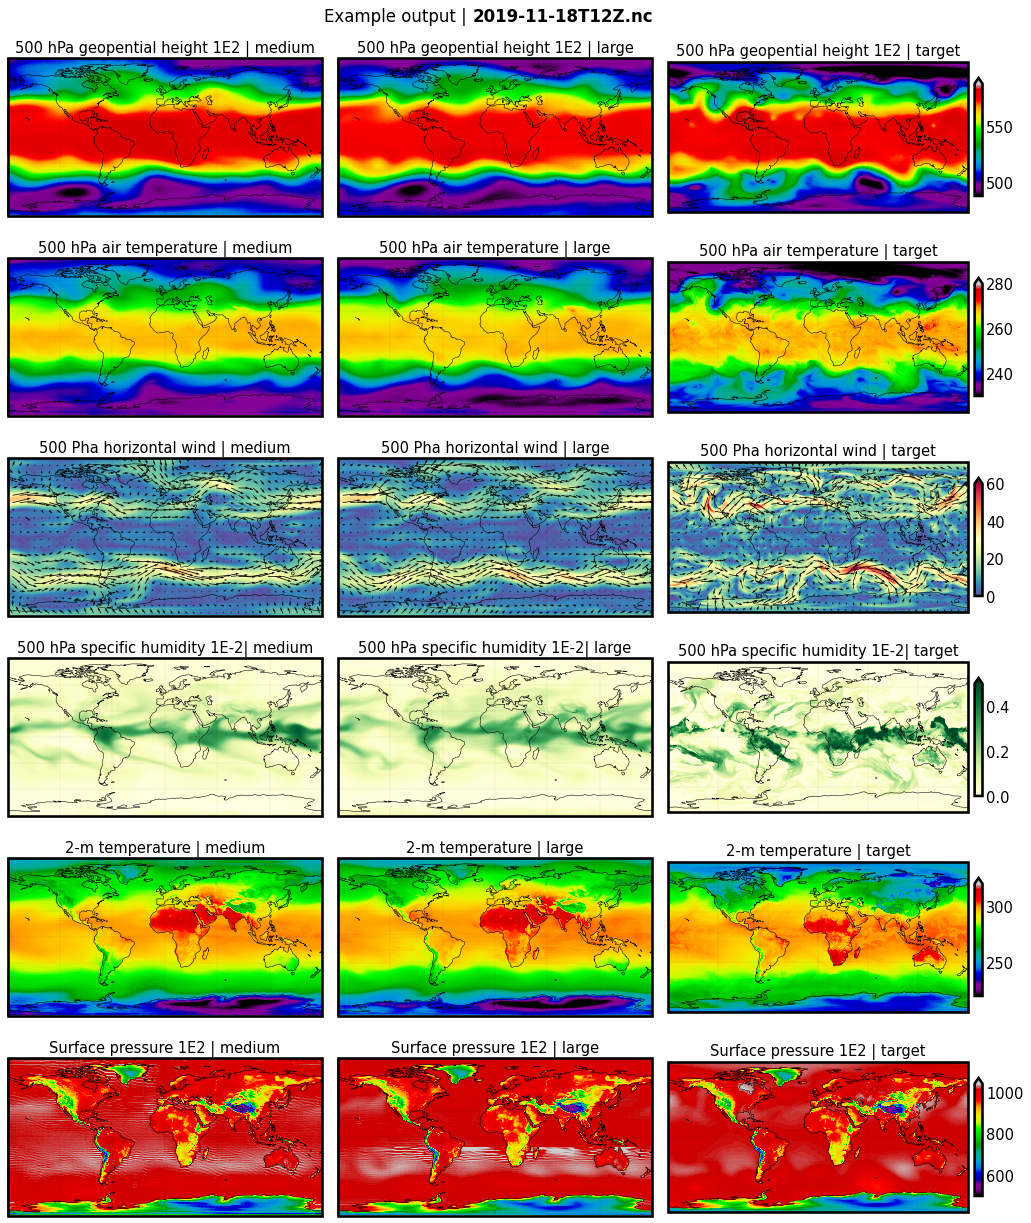

In [16]:
model_names = ['medium', 'large', 'target']

viridis_plasma = gu.cmap_combine(plt.cm.viridis, plt.cm.plasma_r)
pcolor_keys = {
    'Z500' :  {'vmin':488, 'vmax':588, 'cmap':plt.cm.nipy_spectral},
    'T500' :  {'vmin':230, 'vmax':280, 'cmap':plt.cm.nipy_spectral},
    'UV500':  {'vmin':0  , 'vmax':60 , 'cmap':plt.cm.Spectral_r},
    'Q500' :  {'vmin':0  , 'vmax':0.5, 'cmap':plt.cm.YlGn},
    't2m'  :  {'vmin':220, 'vmax':320, 'cmap':plt.cm.nipy_spectral},
    'SP'   :  {'vmin':500, 'vmax':1040,'cmap':plt.cm.nipy_spectral}
}

scales = [1e-2, 1, 1, 1e2, 1, 1e-2]

titles = ['500 hPa geopential height 1E2 | {}', 
          '500 hPa air temperature | {}',
          '500 Pha horizontal wind | {}',
          '500 hPa specific humidity 1E-2| {}',
          '2-m temperature | {}',
          'Surface pressure 1E2 | {}']


proj_ = ccrs.PlateCarree(central_longitude=0.0)

fig = plt.figure(figsize=(13, 16), dpi=dpi_)
gs = gridspec.GridSpec(6, 3, height_ratios=[1, 1, 1, 1, 1, 1], width_ratios=[1, 1, 1])

ind_x = [0, 1, 2, 3, 4, 5]
ind_y = [0, 1, 2]

AX = np.zeros((6, 3)).tolist()
AX_flat = []
for ix, ix_gs in enumerate(ind_x):
    for iy, iy_gs in enumerate(ind_y):
        AX[ix][iy] = plt.subplot(gs[ix_gs, iy_gs], projection=proj_)
        AX_flat.append(plt.subplot(gs[ix_gs, iy_gs]))

plt.subplots_adjust(0, 0, 1, 1, hspace=0.0, wspace=0.05)

for ax in AX_flat:
    ax = map_gridline_opt(ax)

#ax.text(0.025, 0.95, titles[i], ha='left', va='top', fontsize=14, transform=ax.transAxes)
for i in range(len(AX)):
    for i_model, model_name in enumerate(model_names):
        ax = AX[i][i_model]
        ax.set_title(titles[i].format(model_name), fontsize=14)

for i_model, model_name in enumerate(model_names):
    for i_var, varname in enumerate(list(pcolor_keys.keys())):
    # ------------------------------------------------------- #
        if varname == 'UV500':
            speed = dict_example['U500_{}'.format(model_name)]**2 + dict_example['V500_{}'.format(model_name)]**2
            speed = np.sqrt(speed)
            CS_ = AX[i_var][i_model].pcolormesh(lon_OURS, lat_OURS, 
                                            scales[i_var]*speed, 
                                            **pcolor_keys[varname])

            AX[i_var][i_model].quiver(lon_OURS[::30, ::30], lat_OURS[::30, ::30], 
                                      dict_example['U500_{}'.format(model_name)][::30, ::30], 
                                      dict_example['V500_{}'.format(model_name)][::30, ::30])
            
            if i_model == 2:
                cbar = colorbar_opt(fig, AX[i_var][i_model], CS_)
        else:
            CS_ = AX[i_var][i_model].pcolormesh(lon_OURS, lat_OURS, 
                                            scales[i_var]*dict_example['{}_{}'.format(varname, model_name)], 
                                            **pcolor_keys[varname])
            if i_model == 2:
                cbar = colorbar_opt(fig, AX[i_var][i_model], CS_)

ax_title1 = fig.add_axes([0.0, 1.005, 1.0, 0.02])
title_len = 0.35
fontsize_list = [16,]*10
fontweight_list = ['normal', 'bold', 'normal', 'bold', 'normal', 'bold', 'normal']
gu.string_partial_format(fig, ax_title1, 0.5*(1-title_len), 1.0, 'left', 'top', 
                         ['Example output | ', os.path.basename(filename_medium[ind_pick]),], 
                         ['k', 'k'], fontsize_list, fontweight_list)
ax_title1.set_axis_off()

if need_publish:
    # Save figure
    fig.savefig(conf['figure']['save_loc']+'example.png', format='png', **conf['figure']['keys'])